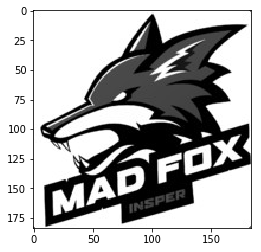

In [1]:
#!/usr/bin/env python
__author__      = "Matheus Dib, Fabio de Miranda"


import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib.cm as cm
from math import pi
from __future__ import print_function
import sys
import math

%matplotlib inline

imagem = 'madfox2.jpg'
madfox = cv2.imread(imagem, cv2.IMREAD_GRAYSCALE)
plt.imshow(madfox,cmap=cm.gray)

In [2]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
lower = 0
upper = 1
# Returns an image containing the borders of the image
# sigma is how far from the median we are setting the thresholds


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged


In [3]:
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # A gaussian blur to get rid of the noise in the image
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #blur = gray
    # Detect the edges present in the image
    bordas = auto_canny(blur)


    circles = []


    # Obtains a version of the edges image where we can draw in color
    bordas_color = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)

    # HoughCircles - detects circles using the Hough Method. For an explanation of
    # param1 and param2 please see an explanation here http://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
    circles = None
    circles=cv2.HoughCircles(bordas,cv2.HOUGH_GRADIENT,2,40,param1=50,param2=100,minRadius=5,maxRadius=60)

    if circles is not None:
        circles = np.uint16(np.around(circles))

        for i in circles[0,:]:
            # draw the outer circle
            # cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]])
            cv2.circle(bordas_color,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(bordas_color,(i[0],i[1]),2,(0,0,255),3)

    # Draw a diagonal blue line with thickness of 5 px
    # cv2.line(img, pt1, pt2, color[, thickness[, lineType[, shift]]])
    cv2.line(bordas_color,(0,0),(511,511),(255,0,0),5)

    # cv2.rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]])
    cv2.rectangle(bordas_color,(384,0),(510,128),(0,255,0),3)    
        
    ###FIM DO CÓDIGO DOS CIRCULOS###
    
    
    MIN_MATCH_COUNT = 10
    img1 = cv2.imread(imagem,0)          # Imagem a procurar
    img2 = frame # Imagem do cenario - puxe do video para fazer isto

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT in each image
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # Configura o algoritmo de casamento de features
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Tenta fazer a melhor comparacao usando o algoritmo
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    if len(good)>MIN_MATCH_COUNT:
        # Separa os bons matches na origem e no destino
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)


        # Tenta achar uma trasformacao composta de rotacao, translacao e escala que situe uma imagem na outra
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        # Transforma os pontos da imagem origem para onde estao na imagem destino
        dst = cv2.perspectiveTransform(pts,M)

        # Desenha as linhas
        img2b = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        
        # cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(bordas_color,'MaDFoX',(0,50), font, 2,(255,255,255),2,cv2.LINE_AA)
        
    else:
        matchesMask = None

        
        
        
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    
    
    # Display the resulting frame
    cv2.imshow('Detector de circulos',bordas_color)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        

    
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()